Input dataset:
- training_data_mv.csv

This notebook includes:
- Test for significance and FDR
- Feature correlation
- Violin plots (continuous features)
- PCA

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy.stats import mannwhitneyu, fisher_exact
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Define paths

In [2]:
Data_path = os.path.dirname(os.path.dirname(os.getcwd())) + '/Data'

# Import dataset

### Feature dataset (Microvesicles)

In [3]:
df = Data_path + '/MachineLearning/training_data_mv.csv' 
df_mv = pd.read_csv(df, sep=',', engine='python')

In [4]:
df_mv

id     length  hydr_count  polar_count  molecular_weight     helix  \
0      Q92667   9.818582    0.376523     0.370986         16.793404  0.079734   
1      P62736   8.558421    0.427056     0.379310         15.574035  0.445623   
2      P0C7M7   9.179909    0.424138     0.379310         16.216178  0.320690   
3      P49703   7.651052    0.417910     0.402985         14.652697  0.328358   
4      Q5TGY3  10.646559    0.331878     0.318777         17.589293  0.097941   
...       ...        ...         ...          ...               ...       ...   
15040  Q96H40   8.854868    0.330454     0.498920         15.918914  0.399568   
15041  Q9BTX3   7.434628    0.514451     0.306358         14.472938  0.624277   
15042  A6NFC5   7.800900    0.560538     0.179372         14.739747  0.573991   
15043  Q8WV44   9.299208    0.365079     0.453968         16.340760  0.296825   
15044  A0PK05   8.103288    0.458182     0.323636         15.087871  0.316364   

           turn     sheet         A         C  ...  coiled_coil  EGF  \
0      0.805094  0.115172  0.079734  0.018826  ...            1    0   
1      0.347480  0.206897  0.076923  0.018568  ...            0    0   
2      0.448276  0.231034  0.058621  0.022414  ...            0    0   
3      0.477612  0.194030  0.099502  0.004975  ...            0    0   
4      0.853400  0.048659  0.104803  0.018715  ...            1    0   
...         ...       ...       ...       ...  ...          ...  ...   
15040  0.494600  0.105832  0.032397  0.056156  ...            0    0   
15041  0.352601  0.023121  0.104046  0.011561  ...            0    0   
15042  0.300448  0.125561  0.121076  0.031390  ...            0    0   
15043  0.528571  0.174603  0.077778  0.030159  ...            0    0   
15044  0.683636  0.000000  0.087273  0.021818  ...            0    0   

       RAS_profile  RRM  ww_domain  transmembrane  TMHMM  Polar_exposed  \
0                0    0          0              1      1       0.447738   
1                0    0          0              0      0       0.682540   
2                0    0          0              0      0       0.661111   
3                0    0          0              0      0       0.567010   
4                0    0          0              0      0       0.411705   
...            ...  ...        ...            ...    ...            ...   
15040            0    0          0              0      0       0.659664   
15041            0    0          0              1      1       0.460674   
15042            0    0          0              1      1       0.310000   
15043            0    0          0              0      0       0.658824   
15044            0    0          0              1      1       0.364078   

       Hydrophobic_exposed  Microvesicle  
0                 0.263651             0  
1                 0.111111             1  
2                 0.088889             0  
3                 0.195876             0  
4                 0.188698             0  
...                    ...           ...  
15040             0.105042             0  
15041             0.382022             0  
15042             0.420000             0  
15043             0.132353             0  
15044             0.412621             0  

[15045 rows x 96 columns]

In [5]:
MV_yes = df_mv[df_mv["Microvesicle"] == 1]
MV_no = df_mv[df_mv["Microvesicle"] == 0]

# Feature analysis

In [6]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Lipoprotein_UP', 'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

### Mann-Whitney U Test

In [7]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(MV_yes[feature], MV_no[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [8]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [9]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

Instability_index p=0.00000
S p=0.00000
turn p=0.00000
D_exposed p=0.00000
Polar_exposed p=0.00000
disorder p=0.00000
L_exposed p=0.00000
K_exposed p=0.00000
S_exposed p=0.00000
C p=0.00000
C_exposed p=0.00000
D p=0.00000
E_exposed p=0.00000
P p=0.00000
H p=0.00000
Hydrophobic_exposed p=0.00000
I p=0.00000
V p=0.00000
H_exposed p=0.00000
charge_at_7 p=0.00000
sheet p=0.00000
P_exposed p=0.00000
K p=0.00000
isoelectric_point p=0.00000
rhsa_netsurfp2 p=0.00000
N_exposed p=0.00000
W_exposed p=0.00000
helix p=0.00000
V_exposed p=0.00000
N p=0.00000
thsa_netsurfp2 p=0.00000
charge_at_5 p=0.00000
I_exposed p=0.00000
F_exposed p=0.00000
Prob. of Solubility p=0.00000
polar_count p=0.00000
hydr_count p=0.00000
Y p=0.00000
W p=0.00000
R p=0.00000
E p=0.00000
M p=0.00000
A p=0.00000
L p=0.00000
Y_exposed p=0.00000
tasa_netsurfp2 p=0.00000
G p=0.00000
R_exposed p=0.00000
Gravy p=0.00000
Q_exposed p=0.00002
Aromaticity p=0.00002
F p=0.00013
Q p=0.00017
Aggregation_propensity p=0.00083
T p=0.00150
G

### Fisher's exact test	

In [10]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(MV_yes[feature]) # EV & positive
    B = len(MV_yes[feature]) - sum(MV_yes[feature]) # EV & negative
    C = sum(MV_no[feature]) # no EV & positive
    D = len(MV_no[feature]) - sum(MV_no[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

In [11]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [12]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))

Palmitoylation_all p=0.00000
Acetylation_all p=0.00000
Nitrosylation_all p=0.00000
Ubiquitination_all p=0.00000
Methylation_all p=0.00000
PTM_UP p=0.00000
Acetylation_MSD p=0.00000
Phosphorylation_all p=0.00000
Lipoprotein_UP p=0.00000
RAS_profile p=0.00000
Prenylation_UP p=0.00000
Ubiquitination_MSD p=0.00000
SUMOylation_all p=0.00000
ISGylation_UP p=0.00000
Nitration_UP p=0.00000
TMHMM p=0.00000
coiled_coil p=0.00000
HSP p=0.00000
Myristoylation_all p=0.00000
SUMOylation_MSD p=0.00000
Citrullination_UP p=0.00001
RRM p=0.00118
Palmitoylation_MSD p=0.00132
EGF p=0.01461
Glycosylation_all p=0.05000
GPI-anchor_UP p=0.19046
Glycosylation_MSD p=0.48959
Methylation_MSD p=0.48959
NEDDylation_UP p=0.48959
Phosphorylation_MSD p=0.51343
PTM_MSD p=0.51343
ww_domain p=0.51343
transmembrane p=0.54523


### Feature correlation

In [13]:
# calculate pairwise correlation
corr_mv = df_mv.corr()

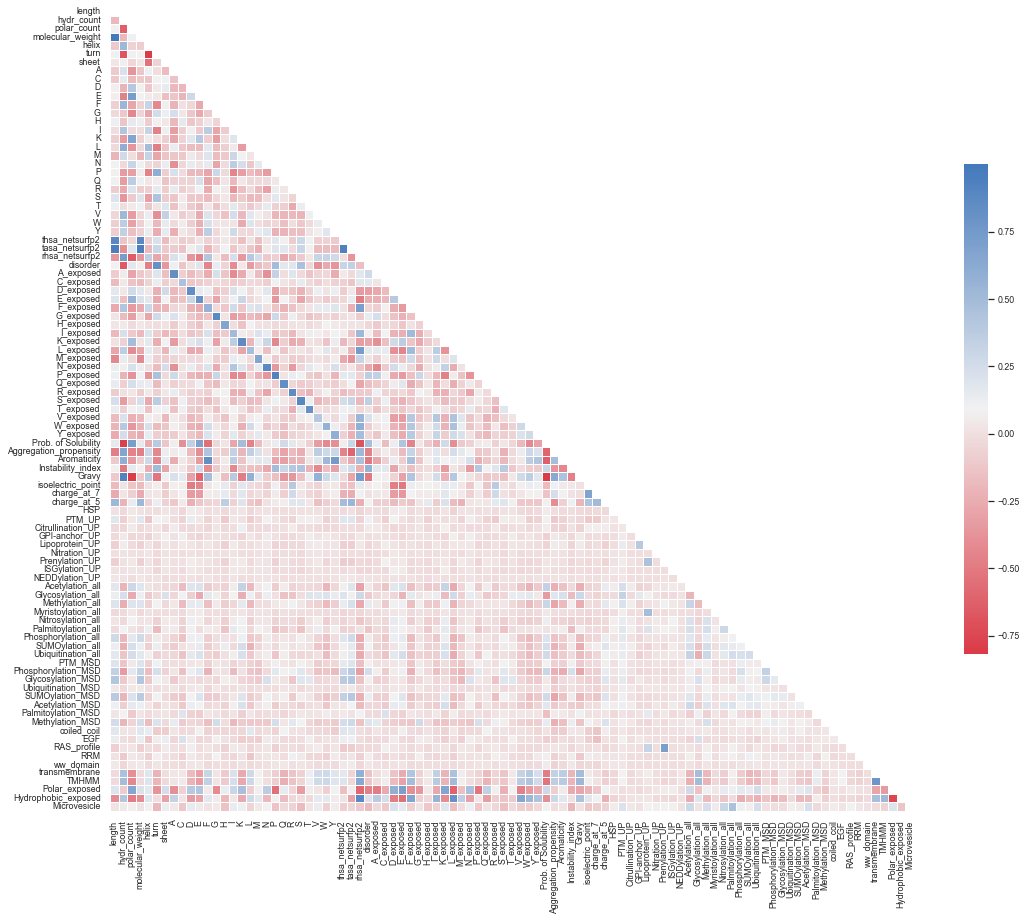

In [14]:
# figure settings
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_mv, dtype=bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_mv, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);

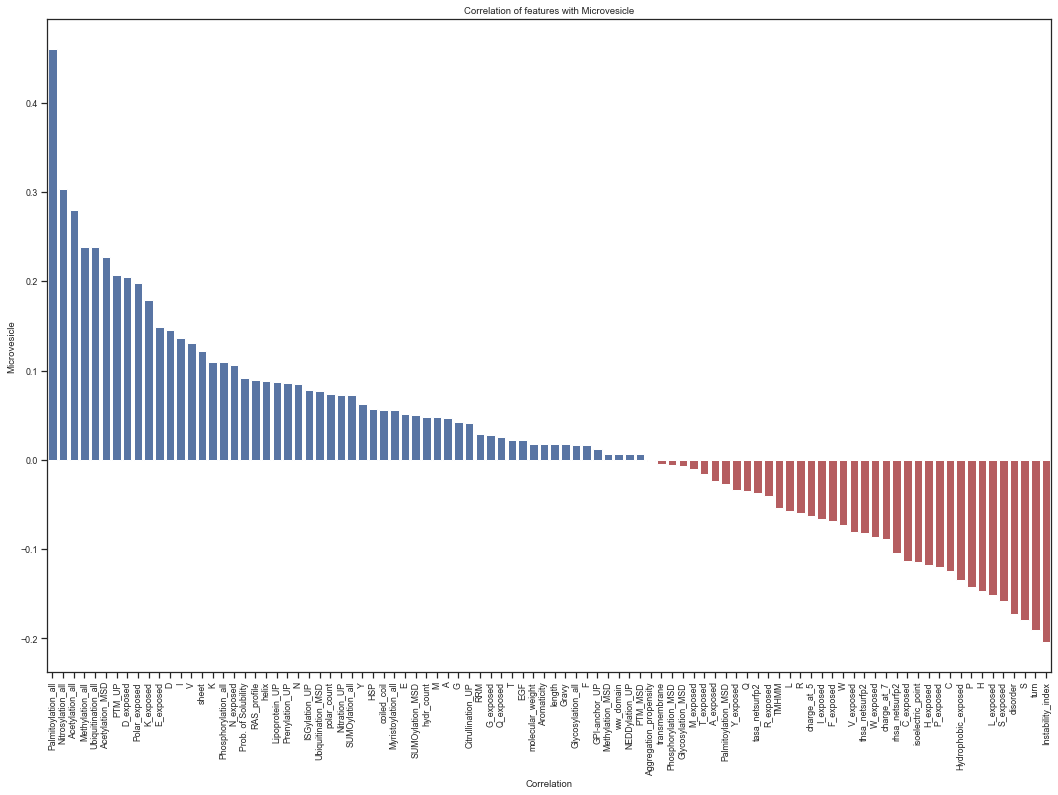

In [15]:
# figure settings
sns.set(style=("ticks"), font_scale=0.8)

correlations_mv = corr_mv[['Microvesicle']].sort_values(by="Microvesicle", ascending=False)[1:]
correlations_mv.reset_index(inplace=True)

colors_mv = ["b" if (x > 0) else "r" for x in correlations_mv["Microvesicle"]]

fig = plt.figure(figsize=(18, 12)) 
sns.barplot(x="index", y="Microvesicle", data=correlations_mv, palette=colors_mv)
plt.xlabel("Features") 
plt.xticks(rotation=90)
plt.xlabel("Correlation")
plt.title("Correlation of features with Microvesicle");

### Violin plots

In [16]:
sns.set(style=("ticks"), font_scale=1.2)
x1, x2 = 0, 1 
my_pal = {1: "lightgreen", 0: "forestgreen"}
dataset = df_mv
labels = ["Microvesicle", "non-Microvesicle"]

#### Physicochemical features

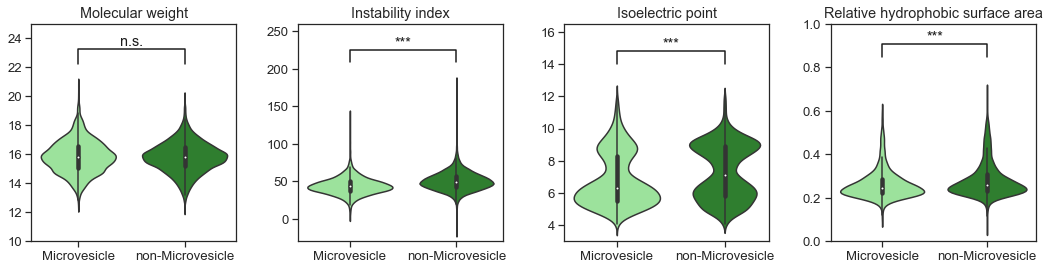

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

sns.violinplot(x=labels[0], y='molecular_weight', data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Molecular weight", xticklabels=(labels), ylim=(10, 25))
y, h, col = dataset['molecular_weight'].max() + 1.5, 1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='Instability_index', data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 260))
y, h, col = dataset['Instability_index'].max() + 25, 15, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='isoelectric_point', data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 16.5))
y, h, col = dataset['isoelectric_point'].max() + 2, 0.8, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='rhsa_netsurfp2', data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Relative hydrophobic surface area", xticklabels=(labels), ylim=(0, 1))
y, h, col = dataset['rhsa_netsurfp2'].max() + 0.15, 0.06, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()

#### Structural features

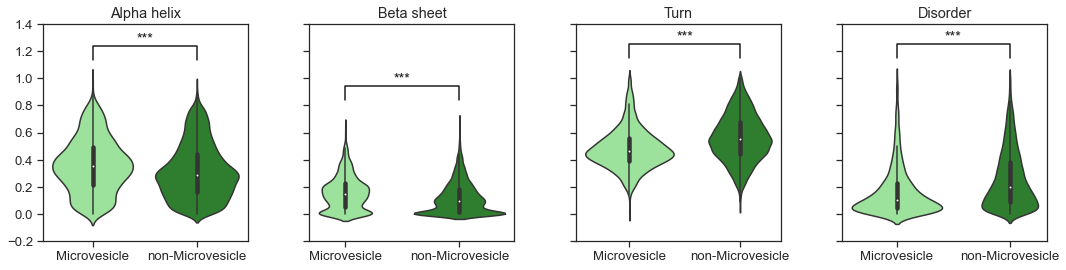

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.4))

sns.violinplot(x=labels[0], y='helix', data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = dataset['helix'].max() + 0.15, 0.1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='sheet', data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = dataset['sheet'].max() + 0.15, 0.1, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='turn', data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = dataset['turn'].max() + 0.15, 0.1, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='disorder', data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels))
y, h, col = dataset['disorder'].max() + 0.15, 0.1, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()

### PCA

In [19]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                       'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                       'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                       'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed', 
                       'Microvesicle']

# scale data before PCA
df_pca = StandardScaler().fit_transform(df_mv[features_continuous])
pca = PCA(n_components=2)
components = pca.fit_transform(df_pca)
# plot first two principal components
fig = px.scatter(components, x=0, y=1, color=df_mv["Microvesicle"])
fig.show()